<a href="https://colab.research.google.com/github/pranay8297/DDPM-DDIM-Karras/blob/main/DDIM_LinearSchedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install --upgrade torch torchvision

  Using cached torchvision-0.20.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# !pip install torch==2.1.0
!pip install datasets
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install wandb
!pip install diffusers
!pip install tqdm
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 11.8 MB/s eta 0:00:00
  Prep

In [3]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import wandb
import time
import numpy

from pathlib import Path
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st

from datasets import load_dataset
from diffusers import UNet2DModel
from accelerate import Accelerator

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2
# from torcheval.metrics import MulticlassAccuracy

from miniai.datasets import *
from miniai.activations import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

Mounted at /content/drive


In [4]:
def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = self.noisify_fn(self, learn.batch[0])

class DDPMPrepV2(DDPMPrep):
  def __init__(self, n_steps = 1000, beta = torch.tensor([0.]), name = 'lin', noisify_fn = noisify_img):
    fc.store_attr()
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

class UnetModel(UNet2DModel):
  def forward(self, x): return super().forward(*x).sample

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def get_callbacks(stats_layer = None):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB()
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

class LossMonitoringCB(Callback):
  def __init__(self): self.losses = [4.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 2:
      print('SOME SHIT HAPPENED')
      st()
    self.losses.append(learn.loss.item())

class MXLearner(TrainLearner):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.scaler = GradScaler()

  @with_cbs('batch')
  def _one_batch(self):
    self.callback('before_predict')
    self.predict()
    self.callback('after_predict')
    self.get_loss()
    self.callback('after_loss')
    if self.training:
      self.backward()
      self.callback('after_backward')
      self.step()
      self.callback('after_step')
      self.zero_grad()

  def predict(self):
    with autocast(device_type='cuda', dtype=torch.float16): super().predict()

  def get_loss(self):
    with autocast(device_type='cuda', dtype=torch.float16): super().get_loss()

  def backward(self): self.scaler.scale(self.loss).backward()

  def step(self):
    self.scaler.step(self.opt)
    self.scaler.update()

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

def scaler(dist, min = 1e-04, max = 2e-02): return min + ((dist - dist.min())/(dist.max() - dist.min())) * (max - min)

def get_cosine_schedule(n_steps = 1000, min = 0.0001, max = 0.02):
  points = torch.linspace(start = math.pi, end = math.pi*2, steps = n_steps)
  dist = (torch.cos(points) + 1.)/2.
  return scaler(dist, min = min, max = max)

def get_exp(n_steps = 1000, min = 0.0001, max = 0.02, x_start = -0.5 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.exp(points), min = min, max = max)

def get_log(n_steps = 1000, min = 0.0001, max = 0.02, x_start = 0.1 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.log(points), min = min, max = max)

class AccLearnerV2(AccLearner):

  def get_sample_batch(self):
    self.batch = next(iter(self.dls.train))
    run_cbs(self.cbs, 'before_batch', self)
    return self.batch

class HackDL():
  def __init__(self, dl, mult = 2):
    self.dl = dl
    self.mult = mult

  def __len__(self):
    return len(self.dl) * self.mult

  def __iter__(self):
    d = next(iter(self.dl))
    for i in range(self.mult):
      yield d

class WandBCB(MetricsCB):
  def __init__(self, *args, project_name = '', log_s = True, **kwargs):
    super().__init__()
    self.log_s = log_s
    self.c = 0
    self.run = wandb.init(
        project = project_name,
        config={
            "epochs": epochs,
        }
    )

  def _log(self, d):
    st()
    log_obj = {}
    for k,v in d.items():
      if k not in ('epoch', 'train'): log_obj[f"{d['train']}_epoch_{k}"] = v
    self.run.log(log_obj)
    return d

  def after_batch(self, learn):
    super().after_batch(learn)
    self.c += 1
    self.run.log({'train_loss': learn.loss.item()} if learn.model.training else {'valid_loss': learn.loss.item()})
    st()
    if self.log_s == True and self.c%200 == 0: self.log_samples(learn)

  def log_samples(self, learn):
    out, _ = sample(learn.model, learn.cbs[-2], out_shape = (8, 3, 32, 32))
    tr = transforms.ToPILImage()
    self.run.log({"Intermediate_Gen": [wandb.Image(tr(i)) for i in -out[-1]]})

def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if act: layers.append(act())
  if norm: layers.append(norm(nf) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a batch norm.
  return nn.Sequential(*layers)

class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'

class ResBlockDV2(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu, p = 0.1, dropout_func = nn.Dropout2d(0.2)):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

class DataAugCB(Callback):
  def __init__(self, tfms = [v2.RandomPerspective(distortion_scale=0.5, p = 1.0), v2.RandomRotation(degrees=(0, 360))], p=0.8):
    self.tfms = transforms.RandomApply(torch.nn.ModuleList(tfms), p = p)

  def before_batch(self, learn):
    if learn.training: learn.batch = (self.tfms(learn.batch[0]), learn.batch[1])

class DropoutCB(Callback):
  def __init__(self, drop_sched): fc.store_attr()
  def before_epoch(self, learn):
    if not learn.training: return
    p = self.drop_sched.step()
    for block in learn.model:
      if isinstance(block, ResBlockDV2): block.drop.p = p
      if isinstance(block, (nn.Dropout, nn.Dropout2d)): block.p = p

class LRScheduler:
  def __init__(self):
    self.batch_count = 0

  def step(self):
    raise NotImplementedError()

class DropoutScheduler(LRScheduler):
  def __init__(self, epochs = 10, min = 0.2, max = 0.5):
    self.drops = iter(torch.linspace(min, max, steps = epochs))

  def step(self):
    return next(self.drops)

def get_model(block = ResBlock, act = GeneralRelu, nfs = [1, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [ResBlockDV2(nfs[i], nfs[i+1], act = act, norm = norm, dropout_func= nn.Dropout2d(p)) for i in range(1, len(nfs) - 1)]
  return nn.Sequential(*layers, AveragePool(), nn.Dropout(p), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

class FID:
  def __init__(self, model = None, targ = None):
    if not model:
      model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
      del model[-1]
      del model[-1]
      del model[-1]

    self.model = model
    self.t_mean, self.t_cov = self._get_stats(targ)

  def _get_stats(self, x):
    index = x.shape[0]
    inp = x
    with torch.no_grad(): acts = self.model(inp)
    return acts.mean(0), acts.T.cov()

  def __call__(self, x):
    i_means, i_cov = self._get_stats(x)
    csr = torch.tensor(sqrtm(i_cov@self.t_cov, blocksize = 256).real)
    return (((i_means-self.t_mean)**2).sum() + i_cov.trace() + self.t_cov.trace() - 2*csr.trace()).item()

class DDIM_Scheduler: # This is only for sampling purposes - All bugs fixed!

  def __init__(self, noise_cb): self.noise_cb = noise_cb

  def set_timesteps(self, ts, skips = 10):
    self.skips = skips
    self.num_timesteps = ts
    self.timesteps = reversed(torch.tensor(range(0, 1000, skips)))

  def _get_alphas(self, ts):

    def _get_alpha(ts, alpha_bar = self.noise_cb.alpha_bar):
      return alpha_bar[ts] if ts >= 0 else torch.tensor(1.)
    prev_ts = ts - self.skips
    return _get_alpha(ts), _get_alpha(prev_ts)

  def _get_variance(self, alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev):
    return (beta_bar_prev / beta_bar) * (1 - alpha_bar / alpha_bar_prev)

  def step(self, xt, np, ts, eta = 0.5):
    # get the current time step and previous timesteps
    # Get alpha bar t and alpha bar t - steps and beta bar t and beta bar t - steps
    # get the x0 hat based on the noise predict
    # calculate the xt-steps using the updated formula

    alpha_bar, alpha_bar_prev = self._get_alphas(ts)
    beta_bar, beta_bar_prev = (1. - alpha_bar), (1. - alpha_bar_prev)
    x0_hat = (xt - beta_bar.sqrt() * np)/(alpha_bar.sqrt()).clip(-1., 1.)
    var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    sigma = (var*eta).sqrt()

    xt_new = alpha_bar_prev.sqrt() * x0_hat + (beta_bar_prev - sigma**2).sqrt() * np + torch.randn(xt.shape).to(xt.device)*sigma
    return xt_new

def ddim_sample(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_Scheduler(DDPMPrepV2(beta = torch.linspace(0.0001, 0.01, 1000)))):

  sched.set_timesteps(n_steps)
  xt = torch.randn(out_shape).to(model.device)
  for ts in tqdm(sched.timesteps):
    with torch.no_grad(): np = model((xt, torch.tensor([ts]*out_shape[0]).to(model.device)))
    xt = sched.step(xt, np, ts, eta = 0.8)
  return xt

def abar_fn(t): return (t*math.pi/2).cos()**2

class DDIM_SchedulerV2: # This is only for sampling purposes - All bugs fixed!

  def __init__(self, abar_fn = abar_fn): fc.store_attr()

  def set_timesteps(self, ts):
    self.num_timesteps = ts
    self.timesteps = reversed(torch.linspace(0, 0.999, ts+1))

  def _get_alphas(self, ts_index):

    def _get_alpha(ts_index):
      try:
        return self.abar_fn(self.timesteps[ts_index])
      except:
        return torch.tensor(1.)

    return _get_alpha(ts_index), _get_alpha(ts_index + 1)

  def _get_variance(self, alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev):
    return (beta_bar_prev / beta_bar) * (1 - alpha_bar / alpha_bar_prev)

  def step(self, xt, np, ts_index, eta = 0.8):
    # get the current time step and previous timesteps
    # Get alpha bar t and alpha bar t - steps and beta bar t and beta bar t - steps
    # get the x0 hat based on the noise predict
    # calculate the xt-steps using the updated formula

    alpha_bar, alpha_bar_prev = self._get_alphas(ts_index)
    beta_bar, beta_bar_prev = (1. - alpha_bar), (1. - alpha_bar_prev)
    x0_hat = (xt - beta_bar.sqrt() * np)/(alpha_bar.sqrt()).clip(-1., 1.)
    var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    sigma = (var*eta).sqrt()

    xt_new = alpha_bar_prev.sqrt() * x0_hat + (beta_bar_prev - sigma**2).sqrt() * np + torch.randn(xt.shape).to(xt.device)*sigma
    return xt_new

def ddim_sample_v2(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_SchedulerV2()):

  sched.set_timesteps(n_steps)
  xt = torch.randn(out_shape).to(model.device)
  for ts_index in tqdm(range(len(sched.timesteps)-1)):
    ts = sched.timesteps[ts_index]
    with torch.no_grad(): np = model((xt, torch.tensor([ts]*out_shape[0]).to(model.device)))
    xt = sched.step(xt, np, ts_index, eta = 0.8)
  return xt

class NoisifyCB(Callback):
  def __init__(self, noise_function = noisify_img): fc.store_attr()
  def before_batch(self, learn):
    learn.batch = self.noise_function(learn.batch[0])

def inv_abar(abar): return (2/math.pi)*(abar.sqrt()).acos()

# Derived for abar fn - use this range instead of 0, 0.999
trange = (torch.tensor(0.0064), torch.tensor(0.9494))

In [5]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)) - 0.5 for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

x, y = next(iter(dls.train))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = self.noisify_fn(self, learn.batch[0])

In [16]:
def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device:
    cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)
    cb_obj.beta_bar = cb_obj.beta_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (cb_obj.beta_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

class DDIM_Linear_SD(Callback):
  def __init__(self, n_steps = 1000, noisify_fn = noisify_img):

    fc.store_attr()

    self.alpha_bar = 1 - torch.linspace(0, 1., n_steps) ** 2
    self.beta_bar = torch.linspace(0, 1., n_steps)**2 # (1 - cum_prod(alpha))**2
    self.gammas = torch.linspace(0, 0.1, n_steps)

  def before_batch(self, learn):
    learn.batch = self.noisify_fn(self, learn.batch[0])

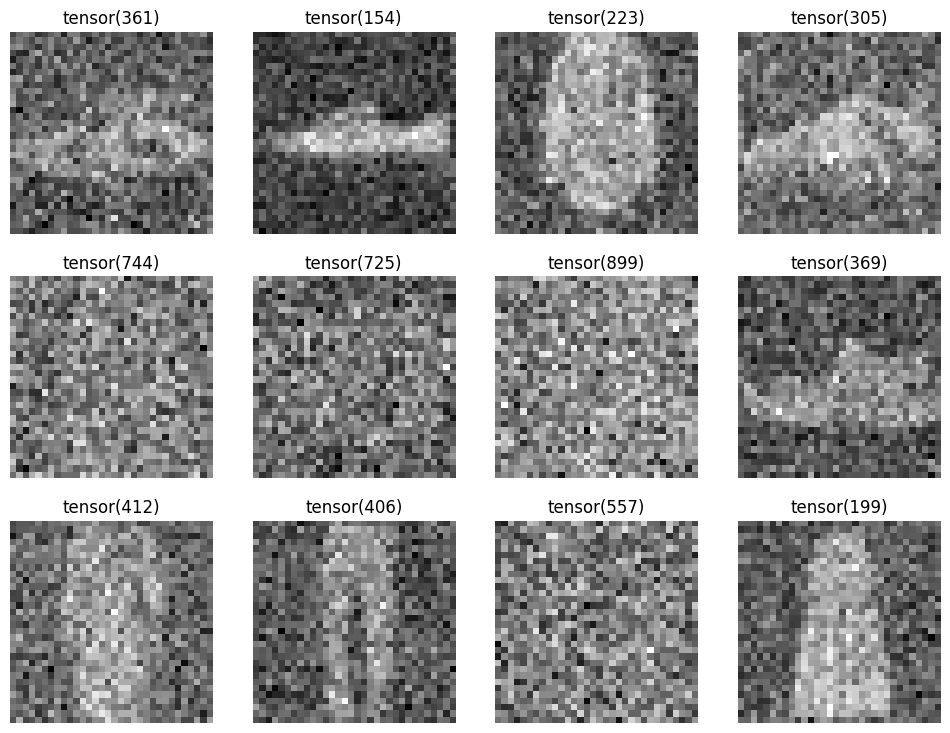

In [11]:
cb_obj = DDIM_Linear_SD(1000, noisify_img)
(noisy_x, ts), noise = noisify_img(cb_obj, x)
show_images(noisy_x[:12], titles = list(ts[:12]))

loss,epoch,train
0.169,0,train
0.080,0,eval
0.068,1,train
0.061,1,eval
0.058,2,train
0.055,2,eval
0.053,3,train
0.051,3,eval
0.050,4,train
0.050,4,eval


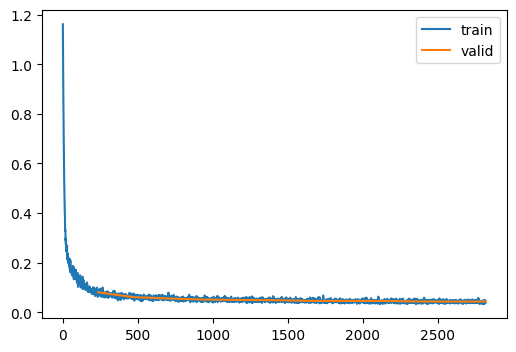

In [17]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))

lr_max, epochs = 3e-03, 12
dls = DataLoaders.from_dd(tds, 256, num_workers=2)

cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDIM_Linear_SD(1000),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]

learner = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
learner.fit(epochs)

In [12]:
torch.save(learner.model, mdl_path/'ddim_linear_noise_sd_trained_12_ep.pkl')

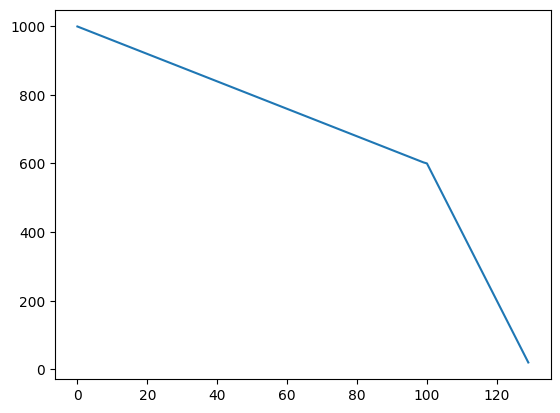

In [28]:
plt.plot(list(range(999, 600, -4)) + list(range(600, 0, -20)))

In [30]:
a = list(range(999, 600, -4))
b = list(range(600, 0, -20))
a[0], a[-1], b[0], b[-1]

(999, 603, 600, 20)

In [52]:
class DDIM_SchedulerV2: # This is only for sampling purposes

  def __init__(self, noise_cb): self.noise_cb = noise_cb

  def set_timesteps(self):

    ts = list(range(998, 600, -4)) + list(range(600, 0, -20))
    if ts[-1] != 0: ts.append(0)

    self.num_timesteps = len(ts)
    self.timesteps = ts

    self.cts_idx = 0

  def _get_alpha_beta(self, cts, pts):

    def _get_alpha(ts, alpha_bar = self.noise_cb.alpha_bar, beta_bar = self.noise_cb.beta_bar):
      return (alpha_bar[ts] if ts > 0 else torch.tensor(1.), beta_bar[ts] if ts > 0 else torch.tensor(0.))


    return _get_alpha(cts), _get_alpha(pts)

  def _get_variance(self, alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev):
    return (beta_bar_prev / beta_bar) * (1 - alpha_bar / alpha_bar_prev)

  def step_new(self, xt, model, eta = 0.5):
    # get the current time step and previous timesteps
    # Get alpha bar t and alpha bar t - steps and beta bar t and beta bar t - steps
    # get the x0 hat based on the noise predict
    # calculate the xt-steps using the updated formula
    # breakpoint()

    # if ts == 0: breakpoint()

    cts = self.timesteps[self.cts_idx]
    pts = self.timesteps[self.cts_idx+1]

    np = model((xt, torch.tensor([cts]*xt.shape[0]).to(model.device)))

    (alpha_bar, beta_bar), (alpha_bar_prev, beta_bar_prev) = self._get_alpha_beta(cts, pts)
    # beta_bar, beta_bar_prev = (1. - alpha_bar), (1. - alpha_bar_prev)

    x0_hat = (xt - beta_bar.sqrt() * np)/(alpha_bar.sqrt()).clip(-1., 1.)

    # var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    # var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    # sigma = (var*eta).sqrt()
    sigma = 0
    # sigma = self.noise_cb.gammas[ts]

    xt_new = alpha_bar_prev.sqrt() * x0_hat + (beta_bar_prev - sigma**2).sqrt() * np + torch.rand_like(xt).to(xt.device)*sigma
    self.cts_idx += 1
    return xt_new

def ddim_sample_v3(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_SchedulerV2(DDIM_Linear_SD(1000))):

  sched.set_timesteps()
  xt = torch.randn(out_shape).to(model.device)
  with torch.no_grad():
    for _ in range(len(sched.timesteps)-1):

      xt = sched.step_new(xt, model, eta = 0.8)
      print(f"ts: {ts}, mean: {xt.mean():.5f}, std: {xt.std():.5f}")
      if xt.isnan().any():
        print('wtf')
      if sched.cts_idx + 1 == len(sched.timesteps):
        break

  return xt

In [53]:
out = ddim_sample_v3(model)

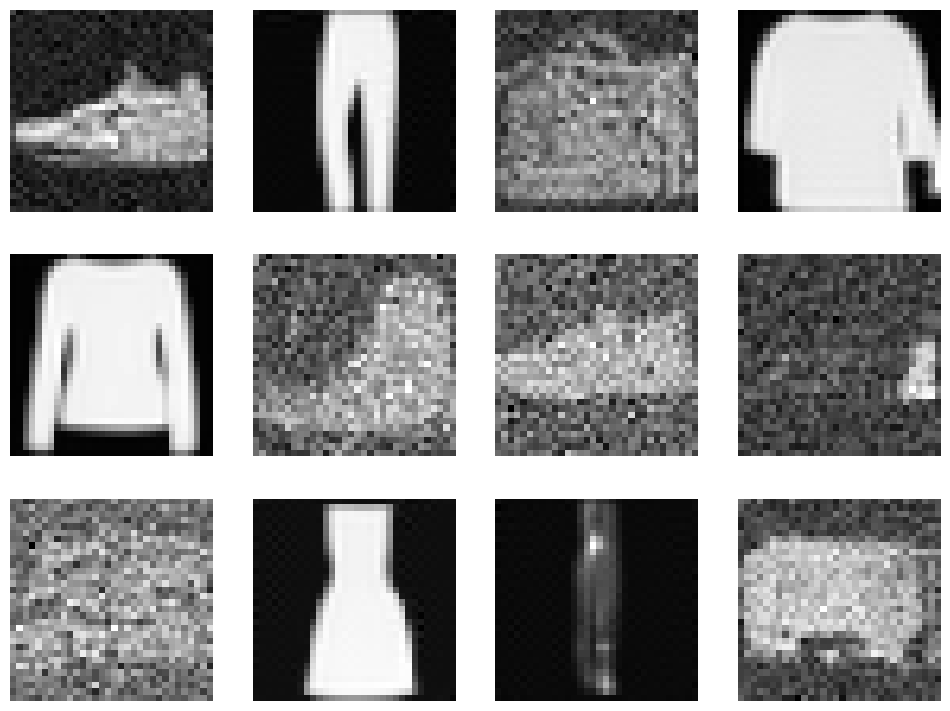

In [54]:
show_images(out[:12])